## 3) Working with simulation data

**Load the simulation snapshot**

Pluto TD simulation data from Giovanni Picogna

In [1]:
# Import radmc3dPy library
import radmc3dPy
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as c
# Use pickle files to load the simulation data
import pickle

main_dir = os.getcwd()      # directory of the tutorial

sim = pickle.load( open( main_dir+"/data/data.0500.dbl.p", "rb" ) )

# Unpack data
#
# Cylindrical coordinates
x = sim['x']
y = sim['y']
z = sim['z']
xi = sim['xi']
yi = sim['yi']
zi = sim['zi']

# Spherical coordinates
r = np.sqrt(x[0,:,:]**2+y[0,:,:]**2+z[0,:,:]**2)
th = np.arccos(z[0,:,:]/r).value
ph = np.arctan2(y[0,:,:],x[0,:,:]).value
r = r.value

ri = np.sqrt(xi[0,:,:]**2+yi[0,:,:]**2+zi[0,:,:]**2)
thi = np.arccos(zi[0,:,:]/ri).value
phi = np.arctan2(yi[0,:,:],xi[0,:,:]).value
ri = ri.value

rho = sim['rho']
temp = sim['temp']
vr = sim['vr']
vth = sim['vth']
vph = sim['vph']

/home/laci/.local/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log10
/usr/lib/python2.7/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


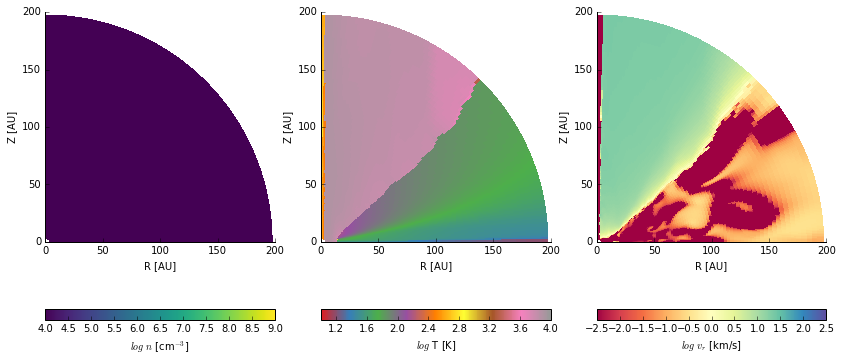

In [2]:
fig , ax  = plt.subplots(1,3,sharey=False,figsize=[14.,8.])

X    = x[0].value
Z    = z[0].value

mu = 1.4             # mean particle mass
mp = 1.66053886e-24  # protonmass

for i in range(3):
    ax[i].set_xlim(0,200)
    ax[i].set_ylim(0,200)
    ax[i].set_aspect('equal')
    ax[i].set_xlabel('R [AU]')
    ax[i].set_ylabel('Z [AU]')
    if (i==0):
        valmin = 4
        valmax = 9
        quantity = np.log10(rho/mu*mp)
        labelplot = '$log$ $n$ [cm$^{-3}$]'
        levels = [4.5,5.,5.5,6.5,7.4,8.9]
        cmap = 'viridis'
    if (i==1):
        valmin = 1
        valmax = 4.
        quantity = np.log10(temp)
        labelplot = '$log$ T [K]'
        levels = [None]
        cmap = 'Set1'
    if (i==2):
        valmin = -2.5
        valmax = 2.5
        quantity = np.log10((vr*u.cm/u.s).to(u.km/u.s).value)
        labelplot = '$log$ $v_r$ [km/s]'
        levels = [4.5,5.,5.5,6.5,7.4,8.9]
        cmap = 'Spectral'

    plot = ax[i].pcolormesh((X*u.cm).to(u.AU).value,(Z*u.cm).to(u.AU).value,quantity,
                            vmin=valmin,vmax=valmax,cmap=cmap)
    cont = ax[i].contour((X*u.cm).to(u.AU).value,(Z*u.cm).to(u.AU).value,quantity,levels,colors='black',
                        linewiths=0.5,linestyles='dashed')
    fig.colorbar(plot, ax=ax[i], orientation='horizontal', label=labelplot)  

    ax[i].tick_params(top='off', bottom='on', left='on', right='off', labelleft='on', labelbottom='on')
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(True)
    ax[i].spines["bottom"].set_visible(True)

**Create RADMC-3D input**

Keep in mind that:

0. **In RADMC-3D all units are cgs**!!
1. Quantities are defined in cell center, the grid is defined at cell interfances.
2. In spherical coordinate system, mirror symmetry model: $0 < \theta < \pi/2$
3. Radiation source facing cells should be optically thin(-ish). In some cases grid refinement is needed.
4. The wavelength grid must cover the SED of radiation source. 
5. The same wavelength grid should be specified in wavelength_micron.inp and stars.inp
6. gas_{temperature,velocity}.inp, numberdensity_{species}.inp have the same structure

In [3]:


work_dir = '/radmc3d_pluto'
os.path.isdir(main_dir+work_dir) 
if not os.path.isdir(main_dir+work_dir):
    os.makedirs(main_dir+work_dir)

DIMP = x.shape[0]
DIMT = x.shape[1]
DIMR = x.shape[2]

gastodust = 100.

# Write amr_grid.binp
#
fout = open(main_dir+work_dir+'/amr_grid.inp','w')
fout.write('{:8n}\n'.format(1))                     # iformat
fout.write('{:8n}\n'.format(0))                     # AMR grid style (0=regular grid, no AMR)
fout.write('{:8n}\n'.format(100))                   # Coordinate system (100 spherical)
fout.write('{:8n}\n'.format(0))                     # gridinfo
fout.write('{:8n}  {:8n}  {:8n}\n'.format(1,1,0))   # Include x,y,z coordinate
fout.write('{:8n}  {:8n}  {:8n}\n'.format(DIMR,DIMT,DIMP)) # grid size
for ix in range(DIMR+1):                            # write cell interface coordinates (therefore the +1)
    fout.write('{:11.6E}\n'.format(ri[0,ix]))
for it in range(DIMT+1):                            # write cell interface coordinates (therefore the +1)
    if (it <= DIMT):
        fout.write('{:11.6E}\n'.format( (thi[it,0]) )) 
    else:                                                  # th must be smaller than pi/2
        fout.write('{:11.6}\n'.format( (thi[it,0]-1e-4) )) # make sure that it is smaller
for ip in range(DIMP+1):                            # write cell interface coordinates (therefore the +1)
    fout.write('{:11.6E}\n'.format(phi[0,0]))
fout.close()


# Write the density file
#
gastodust = 100.
fout = open(main_dir+work_dir+'/dust_density.inp','w')
fout.write('{:8n}\n'.format(1))                      # Format number
fout.write('{:8n}\n'.format(DIMR*DIMT*DIMP))         # Nr of cells
fout.write('{:8n}\n'.format(1))                      # Nr of dust species
for ip in range(DIMP):
    for it in range(DIMT):
        for ir in range(DIMR):
            fout.write('{:11.4E}\n'.format(rho[it,ir]/gastodust))
fout.close()


# Write gas/dust temperature
#
gastodust = 100.
fout = open(main_dir+work_dir+'/gas_temperature.inp','w')
fout.write('{:8n}\n'.format(1))                      # Format number
fout.write('{:8n}\n'.format(DIMR*DIMT*DIMP))         # Nr of cells
for ip in range(DIMP):
    for it in range(DIMT):
        for ir in range(DIMR):
            fout.write('{:11.4E}\n'.format(temp[it,ir]))
fout.close()

# Write velocities
#
fout = open(main_dir+work_dir+'/gas_velocity.inp','w')
fout.write('{:8n}\n'.format(1))                      # Format number
fout.write('{:8n}\n'.format(DIMR*DIMT*DIMP))         # Nr of cells
for ip in range(DIMP):
    for it in range(DIMT):
        for ir in range(DIMR):
            fout.write('{:11.4E}  {:11.4E}  {:11.4E}\n'.format(vr[it,ir],vth[it,ir],vph[it,ir]))
fout.close()

# wavelength ranges
#
nlam = 400
lam     = 10.0**np.linspace(-1,4,nlam) * u.micrometer

# Write the wavelength file
#
fout = open(main_dir+work_dir+'/wavelength_micron.inp','w')
fout.write('{:8n}\n'.format(nlam))                   # Number of wavelengths
for il in range(nlam):
    fout.write('{:11.4E}\n'.format(lam[il].value))
fout.close()

# Star parameters
#
mstar    = 0.7 * u.solMass
rstar    = 2.076 * u.solRad                          # According Baraffe et al.      
tstar    = 3862.00 * u.K                             # According Baraffe et al. 
pstar    = [0.,0.,0.]

# Write the stars.inp file
#
fout = open(main_dir+work_dir+'/stars.inp','w')
fout.write('{:8n}\n'.format(2))                      # Format number
fout.write('{:8n}  {:8n}\n\n'.format(1,nlam))        # Number of wavelengths
fout.write('{:11.4E}  {:11.4E}  {:11.4E}  {:11.4E}  {:11.4E}\n\n'.format(
    rstar.to(u.cm).value,mstar.to(u.gram).value,pstar[0],pstar[1],pstar[2]))
for il in range(nlam):
    fout.write('{:11.4E}\n'.format(lam[il].value))   # Nr of cells
fout.write('\n{:11.4E}'.format(-tstar.value))        # -tstar -> Black body radiation tstar temp.
fout.close()

# RADMC-3D control file
#
fout = open(main_dir+work_dir+'/radmc3d.inp','w')
fout.write('nphot = 1000000\n')
fout.write('scattering_mode_max = 0\n')
fout.write('istar_sphere = 1\n')
fout.write('modified_random_walk = 1\n')
fout.close()

# Opacity files
#
dustkappafile = '/dustkappa_silicate.inp'
shutil.copy(main_dir+'/data'+dustkappafile, main_dir+work_dir+dustkappafile)
fout = open(main_dir+work_dir+'/dustopac.inp','w')
fout.write('{:4n}\n'.format(2))                      # Format number
fout.write('{:4n}\n'.format(1))                      # Nr of species
fout.write('===================\n')
fout.write('{:4n}\n'.format(1))                      # Inputstyle
fout.write('{:4n}\n'.format(0))                      # Quantum heated?
fout.write('silicate')
fout.write('\n-------------------\n')
fout.close()

To run the code on multiple threads:

In [4]:
os.chdir(main_dir+work_dir)

!radmc3d mctherm setthreads 4

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
        This is the 3-D reincarnation of the 2-D RADMC code      
                (c) 2010/2015 Cornelis Dullemond                 
                                                                 
 ************* NOTE: THIS IS STILL A BETA VERSION ***************
 ****** Some modes/capabilities are not yet ready/mature ********
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
      the RADMC-3D mailing list by sending an email to me:       
                    dullemond@uni-heidelberg.de                  
       

 Thread:           2 Photon nr:      111000
 Thread:           3 Photon nr:      112000
 Thread:           1 Photon nr:      113000
 Thread:           0 Photon nr:      114000
 Thread:           3 Photon nr:      115000
 Thread:           3 Photon nr:      116000
 Thread:           1 Photon nr:      117000
 Thread:           0 Photon nr:      118000
 Thread:           2 Photon nr:      119000
 Thread:           3 Photon nr:      120000
 Thread:           0 Photon nr:      121000
 Thread:           3 Photon nr:      122000
 Thread:           3 Photon nr:      123000
 Thread:           1 Photon nr:      124000
 Thread:           0 Photon nr:      125000
 Thread:           0 Photon nr:      126000
 Thread:           1 Photon nr:      127000
 Thread:           0 Photon nr:      128000
 Thread:           0 Photon nr:      129000
 Thread:           3 Photon nr:      130000
 Thread:           1 Photon nr:      131000
 Thread:           3 Photon nr:      132000
 Thread:           0 Photon nr: 

 Thread:           3 Photon nr:      297000
 Thread:           0 Photon nr:      298000
 Thread:           2 Photon nr:      299000
 Thread:           2 Photon nr:      300000
 Thread:           0 Photon nr:      301000
 Thread:           3 Photon nr:      302000
 Thread:           2 Photon nr:      303000
 Thread:           0 Photon nr:      304000
 Thread:           3 Photon nr:      305000
 Thread:           2 Photon nr:      306000
 Thread:           1 Photon nr:      307000
 Thread:           2 Photon nr:      308000
 Thread:           0 Photon nr:      309000
 Thread:           3 Photon nr:      310000
 Thread:           3 Photon nr:      311000
 Thread:           2 Photon nr:      312000
 Thread:           3 Photon nr:      313000
 Thread:           3 Photon nr:      314000
 Thread:           1 Photon nr:      315000
 Thread:           0 Photon nr:      316000
 Thread:           3 Photon nr:      317000
 Thread:           3 Photon nr:      318000
 Thread:           1 Photon nr: 

 Thread:           0 Photon nr:      484000
 Thread:           3 Photon nr:      485000
 Thread:           1 Photon nr:      486000
 Thread:           0 Photon nr:      487000
 Thread:           2 Photon nr:      488000
 Thread:           1 Photon nr:      489000
 Thread:           1 Photon nr:      490000
 Thread:           0 Photon nr:      491000
 Thread:           1 Photon nr:      492000
 Thread:           3 Photon nr:      493000
 Thread:           3 Photon nr:      494000
 Thread:           1 Photon nr:      495000
 Thread:           0 Photon nr:      496000
 Thread:           1 Photon nr:      497000
 Thread:           3 Photon nr:      498000
 Thread:           0 Photon nr:      499000
 Thread:           0 Photon nr:      500000
 Thread:           2 Photon nr:      501000
 Thread:           3 Photon nr:      502000
 Thread:           0 Photon nr:      503000
 Thread:           0 Photon nr:      504000
 Thread:           3 Photon nr:      505000
 Thread:           1 Photon nr: 

 Thread:           1 Photon nr:      671000
 Thread:           3 Photon nr:      672000
 Thread:           3 Photon nr:      673000
 Thread:           3 Photon nr:      674000
 Thread:           0 Photon nr:      675000
 Thread:           2 Photon nr:      676000
 Thread:           2 Photon nr:      677000
 Thread:           3 Photon nr:      678000
 Thread:           0 Photon nr:      679000
 Thread:           1 Photon nr:      680000
 Thread:           0 Photon nr:      681000
 Thread:           1 Photon nr:      682000
 Thread:           2 Photon nr:      683000
 Thread:           3 Photon nr:      684000
 Thread:           3 Photon nr:      685000
 Thread:           2 Photon nr:      686000
 Thread:           2 Photon nr:      687000
 Thread:           0 Photon nr:      688000
 Thread:           1 Photon nr:      689000
 Thread:           3 Photon nr:      690000
 Thread:           1 Photon nr:      691000
 Thread:           2 Photon nr:      692000
 Thread:           3 Photon nr: 

 Thread:           1 Photon nr:      858000
 Thread:           3 Photon nr:      859000
 Thread:           2 Photon nr:      860000
 Thread:           0 Photon nr:      861000
 Thread:           1 Photon nr:      862000
 Thread:           2 Photon nr:      863000
 Thread:           0 Photon nr:      864000
 Thread:           3 Photon nr:      865000
 Thread:           2 Photon nr:      866000
 Thread:           3 Photon nr:      867000
 Thread:           1 Photon nr:      868000
 Thread:           0 Photon nr:      869000
 Thread:           1 Photon nr:      870000
 Thread:           0 Photon nr:      871000
 Thread:           3 Photon nr:      872000
 Thread:           0 Photon nr:      873000
 Thread:           1 Photon nr:      874000
 Thread:           2 Photon nr:      875000
 Thread:           0 Photon nr:      876000
 Thread:           1 Photon nr:      877000
 Thread:           3 Photon nr:      878000
 Thread:           2 Photon nr:      879000
 Thread:           2 Photon nr: 

Note: Always compare results from parallel runs to single core runs (recompile RADMC-3D without -fopen) before publishing

### Dust continuum image:

Create image at 1.3 mm, incl. = 60 deg, p.a. = 30 deg, 400 by 400 px:

!radmc3d image lambda 1300 incl 60 posang 30 npix 400

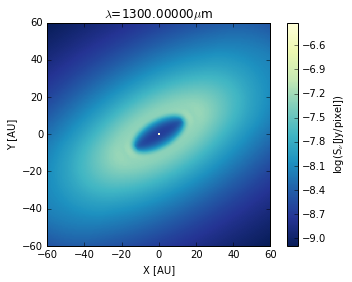

{'cbar': <matplotlib.colorbar.Colorbar at 0x7f57a9a464d0>,
 'implot': <matplotlib.image.AxesImage at 0x7f57a9ab4dd0>}

In [5]:
# Using radmc3dPy package:

os.chdir(main_dir+work_dir)

# !radmc3d mctherm

radmc3dPy.image.makeImage(npix=400, incl=60., posang=30., 
                          wav=1300., sizeau=120,
                          fluxcons=True,nostar=False)
img =radmc3dPy.image.readImage()
radmc3dPy.image.plotImage(img,bunit='snu',dpc=150,log=True,au=True,cmap='YlGnBu_r')


### Create a line emission map

Let's again construct the CO number density distribution by simple assumptions:

1) if T $\geq$ 30 K then $\chi_\mathrm{CO} = 1.4\times10^{-4}$

2) if T $<$ 30 K then $\chi_\mathrm{CO} = 1.0\times10^{-8}$

Note that freeze-out of CO dominates at around 19 K, here we choose the higher value for illustrative purposes.

In [6]:
mu = 1.4             # mean particle mass
mp = 1.66053886e-24  # protonmass
xco = 1.4e-4         # CO abundance
xco_cold = 1e-8      # CO abundance where the temperature is below 30 K
# Write the CO number desnity file
#
gastodust = 100.
fout = open(main_dir+work_dir+'/numberdens_co.inp','w')
fout.write('{:8n}\n'.format(1))                      # Format number
fout.write('{:8n}\n'.format(DIMR*DIMT*DIMP))         # Nr of cells
fout.write('{:8n}\n'.format(1))                      # Nr of dust species
for ip in range(DIMP):
    for it in range(DIMT):
        for ir in range(DIMR):
            if temp[it,ir] < 30.:
                xco_tmp = xco_cold
            else:
                xco_tmp = xco
            fout.write('{:11.4E}\n'.format(rho[it,ir] / (mu*mp) * xco_tmp))
fout.close()

# Copy the dust opacity file
shutil.copy(main_dir+'/data/molecule_co.inp','.')

In [7]:
%%file lines.inp
2
1
co leiden 0  0  0

Writing lines.inp


In [8]:
!radmc3d spectrum iline 1 incl 60 posang 30 nodust widthkms 5

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
        This is the 3-D reincarnation of the 2-D RADMC code      
                (c) 2010/2015 Cornelis Dullemond                 
                                                                 
 ************* NOTE: THIS IS STILL A BETA VERSION ***************
 ****** Some modes/capabilities are not yet ready/mature ********
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
      the RADMC-3D mailing list by sending an email to me:       
                    dullemond@uni-heidelberg.de                  
       

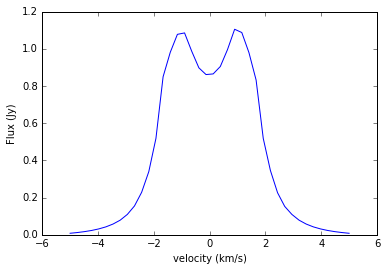

In [9]:
# Plot the spectrum

# Units
ccgs = 2.99792458e10            # cm/s
cmicron = 2.99792458e14         # micron/s
lam0 = 2600.7576334647010       # wavelength of CO (1-0) transition
Jy = 1e-23                      # Jy in erg/s/cm^2/Hz

dpc = 150.                      # Distance to the object in pc

spec = radmc3dPy.analyze.readSpectrum()
lam = spec[:,0]
flux = spec[:,1] / Jy / dpc**2  # Convert to Jy and scale with distancec

# Calculate velocity
nu = cmicron / lam
nu0 = cmicron / lam0
# radio definition
v = ccgs * (1-(nu/nu0)) / 1e5    # km/s

# Plot spectra
plt.plot(v, flux)
plt.xlabel('velocity (km/s)')
plt.ylabel('Flux (Jy)')